# Finetune `wav2vec2` for Thai

This notebook is adapted from [Fine-tuning Wav2Vec2 for English ASR](https://colab.research.google.com/github/patrickvonplaten/notebooks/blob/master/Fine_tuning_Wav2Vec2_for_English_ASR.ipynb) to train Thai ASR using [Common Voice Corpus 7.0](https://commonvoice.mozilla.org/en/datasets).

## What is `wav2vec2`

Wav2Vec2 is a pretrained model for Automatic Speech Recognition (ASR) and was released in [September 2020](https://ai.facebook.com/blog/wav2vec-20-learning-the-structure-of-speech-from-raw-audio/) by Alexei Baevski, Michael Auli, and Alex Conneau.

Using a novel contrastive pretraining objective, Wav2Vec2 learns powerful speech representations from more than 50.000 hours of unlabeled speech. Similar, to [BERT's masked language modeling](http://jalammar.github.io/illustrated-bert/), the model learns contextualized speech representations by randomly masking feature vectors before passing them to a transformer network.

![wav2vec2_structure](https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/wav2vec2.png)

For the first time, it has been shown that pretraining, followed by fine-tuning on very little labeled speech data achieves competitive results to state-of-the-art ASR systems. Using as little as 10 minutes of labeled data, Wav2Vec2 yields a word error rate (WER) of less than 5% on the clean test set of [LibriSpeech](https://huggingface.co/datasets/librispeech_asr) - *cf.* with Table 9 of the [paper](https://arxiv.org/pdf/2006.11477.pdf).

## Installs and Imports

We use SageMaker Studio `Python 3 (Data Science)` image as base.

In [110]:
# !curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.rpm.sh | sudo bash
# !sudo yum install git-lfs -y
# !git lfs install


In [111]:
% % capture
!apt-get update
!apt-get install - -reinstall build-essential - -yes


UsageError: Line magic function `%` not found.


In [112]:
% % capture
%pip install torch == 1.9.0+cpu torchvision == 0.10.0+cpu torchaudio == 0.10.0 - f https: // download.pytorch.org/whl/torch_stable.html
# ? IF Using GPU install torch+cu111
%pip install torch == 1.9.0+cu111 torchvision == 0.10.0+cu111 torchaudio == 0.10.0 - f https: // download.pytorch.org/whl/torch_stable.html
%pip install datasets == 1.11.0
%pip install transformers == 4.9.1
%pip install jiwer
%pip install ipywidgets
%pip install pythainlp == 2.3.1


UsageError: Line magic function `%` not found.


In [113]:
from functools import partial
import pandas as pd
import numpy as np
from datasets import (
    load_dataset,
    load_from_disk,
    load_metric,)
# from datasets.filesystems import S3FileSystem
from transformers import (
    Wav2Vec2CTCTokenizer,
    Wav2Vec2FeatureExtractor,
    Wav2Vec2Processor,
    Wav2Vec2ForCTC,
    TrainingArguments,
    Trainer,
)
import torchaudio
import re
import json
from pythainlp.tokenize import word_tokenize, syllable_tokenize


In [114]:
!df - h


## Data Preparation

### Download

Download and extract to `data/cv-corpus-8.0-2022-01-19-th/th`

In [115]:
# !wget https://voice-prod-bundler-ee1969a6ce8178826482b88e843c335139bd3fb4.s3.amazonaws.com/cv-corpus-8.0-2022-01-19/cv-corpus-8.0-2022-01-19-th.tar.gz
# !tar -xvf cv-corpus-8.0-2022-01-19-th.tar.gz --no-same-owner


### Clean

Clean the datasets as described in `cv-preprocess.ipynb` by [@tann9949](https://github.com/tann9949).

### Load Dataset

We use the [Common Voice Corpus 7.0](https://commonvoice.mozilla.org/en/datasets) which contains 133 validated hours of Thai (255 total hours) at 5GB. We pre-tokenize with `pythainlp.tokenize.word_tokenize`.

In [116]:
datasets = load_dataset("../scripts/th_common_voice_80.py", "th")
datasets


Reusing dataset common_voice (D:\.cache\huggingface\datasets\common_voice\th\8.0.0\11eff7c774afad25f7807c85c6dcf58176c30f1e43956129ba4a2e4b38ab05d9)
100%|██████████| 3/3 [00:00<00:00, 15.21it/s]


DatasetDict({
    train: Dataset({
        features: ['path', 'sentence'],
        num_rows: 98406
    })
    test: Dataset({
        features: ['path', 'sentence'],
        num_rows: 10759
    })
    validation: Dataset({
        features: ['path', 'sentence'],
        num_rows: 10766
    })
})

In [117]:
def preprocess_data(example, tok_func=word_tokenize):
    example['sentence'] = ' '.join(tok_func(example['sentence']))
    return example


datasets = datasets.map(preprocess_data)


Loading cached processed dataset at D:\.cache\huggingface\datasets\common_voice\th\8.0.0\11eff7c774afad25f7807c85c6dcf58176c30f1e43956129ba4a2e4b38ab05d9\cache-11b37ea2ebbd7815.arrow
Loading cached processed dataset at D:\.cache\huggingface\datasets\common_voice\th\8.0.0\11eff7c774afad25f7807c85c6dcf58176c30f1e43956129ba4a2e4b38ab05d9\cache-d7d6bb13a599d1a0.arrow
Loading cached processed dataset at D:\.cache\huggingface\datasets\common_voice\th\8.0.0\11eff7c774afad25f7807c85c6dcf58176c30f1e43956129ba4a2e4b38ab05d9\cache-5a399c6e694e9da4.arrow


### Exploration

#### `sentence`; transcripts

In [137]:
# show random sentences
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML


def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(
        dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))


show_random_elements(
    datasets["train"].remove_columns(["path"]), num_examples=20)


,sentence
0,ศักยภาพ ของ สถาบันการศึกษา แต่ละ แห่ง
1,ฉัน เชื่อ คุณ ที่ ทำให้ สนุก
2,เครื่องประดับ ของ เธอ ระยิบระยับ
3,ประหยัด งบ
4,บริเวณ ภาค ตะวันออกเฉียงเหนือ จะ มี ฝน ตกหนัก เป็น วงกว้าง
5,ใน เมื่อ เขา ไม่ต้องการ รับ ความช่วยเหลือ มัน ก็ ช่วยไม่ได้
6,เสริมสร้าง ความเข้มแข็ง และ แก้ไขปัญหา
7,คุณ คิด อย่างไร กับ เรื่อง นี้
8,ถึง ที่ทำงาน หรือยัง
9,ชายหาด จะ แห้ง และ ตื้น เมื่อ ตอน น้ำลง


<AxesSubplot:>

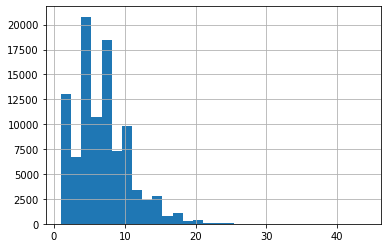

In [119]:
train_df = pd.DataFrame({'sentence': datasets['train']['sentence']})
train_df['nb_words'] = train_df.sentence.map(lambda x: len(x.split()))
train_df.nb_words.hist(bins=30)


<AxesSubplot:>

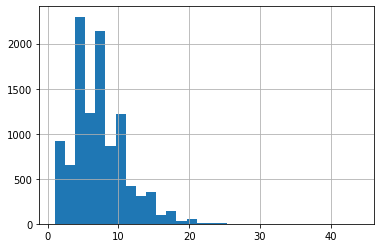

In [120]:
validation_df = pd.DataFrame({'sentence': datasets['validation']['sentence']})
validation_df['nb_words'] = validation_df.sentence.map(
    lambda x: len(x.split()))
validation_df.nb_words.hist(bins=30)


<AxesSubplot:>

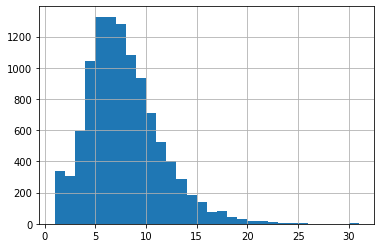

In [121]:
test_df = pd.DataFrame({'sentence': datasets['test']['sentence']})
test_df['nb_words'] = test_df.sentence.map(lambda x: len(x.split()))
test_df.nb_words.hist(bins=30)


#### `path`; mp3 files

In [ ]:
# ! It took too long to process, so, I skip this virsualize part
train_df = pd.DataFrame({'path': datasets['train']['path']})
train_df['sample_rate'] = train_df.path.map(
    lambda x: torchaudio.info(x).sample_rate)
train_df['num_frames'] = train_df.path.map(
    lambda x: torchaudio.info(x).num_frames)
train_df['seconds'] = train_df.num_frames / train_df.sample_rate
train_df.seconds.hist(bins=30)


In [124]:
# ! It took too long to process, so, I skip this virsualize part

# validation_df = pd.DataFrame({'path': datasets['validation']['path']})
# validation_df['sample_rate'] = validation_df.path.map(
#     lambda x: AudioSegment.from_mp3(x).frame_rate)
# validation_df['num_frames'] = validation_df.path.map(
#     lambda x: AudioSegment.from_mp3(x).frame_count())
# validation_df['seconds'] = validation_df.num_frames / validation_df.sample_rate
# validation_df.seconds.hist(bins=30)


In [125]:
# ! It took too long to process, so, I skip this virsualize part

# test_df = pd.DataFrame({'path': datasets['test']['path']})
# test_df['sample_rate'] = test_df.path.map(
#     lambda x: AudioSegment.from_mp3(x).frame_rate)
# test_df['num_frames'] = test_df.path.map(
#     lambda x: AudioSegment.from_mp3(x).frame_count())
# test_df['seconds'] = test_df.num_frames / test_df.sample_rate
# test_df.seconds.hist(bins=30)


### Create Wav2Vec2CTCTokenizer

[Connectionist Temporal Classification (CTC)](https://distill.pub/2017/ctc/) tokenizer is a character-level tokenizer. We uses space (denoted as `|` token) as word delimiter token and `[PAD]` as blank token. 

In [138]:
def extract_all_chars(batch, text_col="sentence"):
    all_text = " ".join(batch[text_col])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}


vocabs = datasets.map(extract_all_chars,
                      batched=True,
                      batch_size=-1,
                      keep_in_memory=True,
                      remove_columns=datasets.column_names["train"])

# vocab_list = list(set(vocabs["train"]["vocab"][0]) | set(vocabs["validation"]["vocab"][0]) | set(vocabs["test"]["vocab"][0]))
vocab_list = list(set(vocabs["train"]["vocab"][0])) #strictly no leakage
vocab_dict = {v: k for k, v in enumerate(vocab_list)}
len(vocab_dict), vocab_dict


100%|██████████| 1/1 [00:00<00:00, 24.38ba/s]


(72,
 {'ฉ': 0,
  'ฒ': 1,
  'ธ': 2,
  'ถ': 3,
  'ิ': 4,
  'ฬ': 5,
  'โ': 6,
  'จ': 7,
  'ผ': 8,
  'ซ': 9,
  ' ': 10,
  'ฐ': 11,
  'พ': 12,
  '็': 13,
  'ฌ': 14,
  'ั': 15,
  'ง': 16,
  '[': 17,
  'ด': 18,
  'า': 19,
  'ช': 20,
  'ไ': 21,
  'ย': 22,
  'ู': 23,
  'น': 24,
  'ฃ': 25,
  '|': 26,
  'ฟ': 27,
  'ื': 28,
  'ว': 29,
  'อ': 30,
  'ฏ': 31,
  'ฎ': 32,
  '_': 33,
  'ณ': 34,
  'เ': 35,
  '์': 36,
  'ข': 37,
  '่': 38,
  'ฤ': 39,
  'ฮ': 40,
  'ฑ': 41,
  'ใ': 42,
  'ษ': 43,
  'ศ': 44,
  'ะ': 45,
  'ล': 46,
  'ญ': 47,
  'ภ': 48,
  'ต': 49,
  'ค': 50,
  'บ': 51,
  'ก': 52,
  'ท': 53,
  ']': 54,
  'ๅ': 55,
  'ฆ': 56,
  'ม': 57,
  'ี': 58,
  '๊': 59,
  '๋': 60,
  'ฯ': 61,
  'ป': 62,
  '้': 63,
  'ร': 64,
  'แ': 65,
  'ำ': 66,
  'ึ': 67,
  'ุ': 68,
  'ส': 69,
  'ห': 70,
  'ฝ': 71})

In [127]:
# make space = |
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]


In [128]:
# padding token serves as blank token
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
len(vocab_dict), vocab_dict


(73,
 {'ฒ': 0,
  'ฬ': 1,
  'โ': 2,
  'จ': 3,
  'พ': 5,
  '็': 6,
  'ง': 7,
  '[': 8,
  'า': 9,
  '|': 4,
  'ฃ': 11,
  'ื': 12,
  'ฏ': 13,
  'ฮ': 14,
  '์': 15,
  'ข': 16,
  'ฤ': 17,
  'ใ': 18,
  'ศ': 19,
  'ล': 20,
  'ญ': 21,
  'บ': 22,
  'ก': 23,
  'ท': 24,
  ']': 25,
  'ๅ': 26,
  'ฆ': 27,
  'ม': 28,
  '๊': 29,
  '้': 30,
  'ร': 31,
  'ุ': 32,
  'ส': 33,
  'ห': 34,
  'ฝ': 35,
  'ฉ': 36,
  'ธ': 37,
  'ถ': 38,
  'ิ': 39,
  'ผ': 40,
  'ซ': 41,
  'ฐ': 42,
  'ั': 43,
  'ด': 44,
  'ฌ': 45,
  'ช': 46,
  'ไ': 47,
  'ย': 48,
  'ู': 49,
  'น': 50,
  'ฟ': 51,
  'ว': 52,
  'อ': 53,
  'ฎ': 54,
  '_': 55,
  'ณ': 56,
  'เ': 57,
  '่': 58,
  'ฑ': 59,
  'ษ': 60,
  'ะ': 61,
  'ภ': 62,
  'ต': 63,
  'ค': 64,
  'ี': 65,
  '๋': 66,
  'ฯ': 67,
  'ป': 68,
  'แ': 69,
  'ำ': 70,
  'ึ': 71,
  '[UNK]': 71,
  '[PAD]': 72})

In [129]:
# save as json; create tokenizer for the first time and upload to hugginface hub
with open('../data/vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)
tokenizer = Wav2Vec2CTCTokenizer("../data/vocab.json",
                                 unk_token="[UNK]",
                                 pad_token="[PAD]",
                                 word_delimiter_token="|")
tokenizer.save_pretrained('../wav2vec2-large-xlsr-53-th')


tokenizer config file saved in ../wav2vec2-large-xlsr-53-th\tokenizer_config.json
Special tokens file saved in ../wav2vec2-large-xlsr-53-th\special_tokens_map.json


('../wav2vec2-large-xlsr-53-th\\tokenizer_config.json',
 '../wav2vec2-large-xlsr-53-th\\special_tokens_map.json',
 '../wav2vec2-large-xlsr-53-th\\vocab.json',
 '../wav2vec2-large-xlsr-53-th\\added_tokens.json')

In [130]:
tokenizer = Wav2Vec2CTCTokenizer.from_pretrained(
    "airesearch/wav2vec2-large-xlsr-53-th")


loading file https://huggingface.co/airesearch/wav2vec2-large-xlsr-53-th/resolve/main/vocab.json from cache at C:\Users\otash/.cache\huggingface\transformers\97445a2b399e97ed06c9b574fb5d0de6c617a2ef1c6a8a866c3da8d59199ada0.e829e370f0e25f78c6143793fc556ec89a45a0ca38012d100d8d5dc7bfbc2330
loading file https://huggingface.co/airesearch/wav2vec2-large-xlsr-53-th/resolve/main/tokenizer_config.json from cache at C:\Users\otash/.cache\huggingface\transformers\6a1b647225eae4dd35eb0aa1e062bb779fa497b780613384f28f495a637c7405.9a832b91e3d317e7bec01bab5134265b75f2d6b05a270d0140d8a116c51b8591
loading file https://huggingface.co/airesearch/wav2vec2-large-xlsr-53-th/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/airesearch/wav2vec2-large-xlsr-53-th/resolve/main/special_tokens_map.json from cache at C:\Users\otash/.cache\huggingface\transformers\e2f4de852e6b998b568b7742262188577a6228605e0c618af06f515e567e5345.a21d51735cf8667bcd610f057e88548d5d6a381401f6b4501a8bc6

In [131]:
datasets['train'][0]['sentence']


'ยี่ สิบห้า'

In [132]:
tokenizer(datasets['train'][0]['sentence'])


{'input_ids': [24, 32, 15, 42, 67, 64, 33, 40, 7, 16], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [133]:
tokenizer.decode(tokenizer(datasets['train'][0]['sentence']).input_ids)


'ยี่ สิบห้า'

In [79]:
tokenizer.vocab_size


70

### Create Wav2Vec2 Feature Extractor

Wav2Vec2 was pretrained on the audio data of [LibriSpeech](https://huggingface.co/datasets/librispeech_asr) and LibriVox which both were sampling with 16kHz. [Common Voice Corpus 7.0](https://commonvoice.mozilla.org/en/datasets) has 32kHz sampling rate.

A Wav2Vec2 feature extractor object requires the following parameters to be instantiated:

- `feature_size`: Speech models take a sequence of feature vectors as an input. While the length of this sequence obviously varies, the feature size should not. In the case of Wav2Vec2, the feature size is 1 because the model was trained on the raw speech signal ${}^2$.
- `sampling_rate`: The sampling rate at which the model is trained on.
- `padding_value`: For batched inference, shorter inputs need to be padded with a specific value
- `do_normalize`: Whether the input should be *zero-mean-unit-variance* normalized or not. Usually, speech models perform better when normalizing the input
- `return_attention_mask`: Whether the model should make use of an `attention_mask` for batched inference. In general, models should **always** make use of the `attention_mask` to mask padded tokens. However, due to a very specific design choice of `Wav2Vec2`'s "base" checkpoint, better results are achieved when using no `attention_mask`. This is **not** recommended for other speech models. For more information, one can take a look at [this](https://github.com/pytorch/fairseq/issues/3227) issue. **Important** If you want to use this notebook to fine-tune [large-lv60](https://huggingface.co/facebook/wav2vec2-large-lv60), this parameter should be set to `True`.

In [80]:
feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1,
                                             sampling_rate=16000,
                                             padding_value=0.0,
                                             do_normalize=True,
                                             return_attention_mask=False)


In [81]:
processor = Wav2Vec2Processor(
    feature_extractor=feature_extractor, tokenizer=tokenizer)


### Preprocess Data

We resample to 16kHz with which `wav2vec2` was pretrained on.

In [82]:
import audio2numpy as a2n
import torch
import numpy as np


def load_mp3(path: str):
    r"""replace: torchaudio.load(path) which cannot load .mp3"""
    speech_array, sampling_rate = a2n.audio_from_file(path)
    speech_array = torch.tensor(np.array([speech_array]))
    return speech_array, sampling_rate


In [83]:
def speech_file_to_array_fn(batch,
                            text_col="sentence",
                            fname_col="path",
                            resampling_to=16000):
    # speech_array, sampling_rate = torchaudio.load(batch[fname_col])
    speech_array, sampling_rate = load_mp3(batch[fname_col])
    resampler = torchaudio.transforms.Resample(sampling_rate, resampling_to)
    batch["speech"] = resampler(speech_array)[0].numpy()
    batch["sampling_rate"] = resampling_to
    batch["target_text"] = batch[text_col]
    return batch


In [ ]:
# ! OSError: file not found
speech_datasets = datasets.map(speech_file_to_array_fn,
                               remove_columns=datasets.column_names["train"])
speech_datasets


In [86]:
speech_datasets


DatasetDict({
    train: Dataset({
        features: ['speech', 'sampling_rate', 'target_text'],
        num_rows: 98406
    })
    test: Dataset({
        features: ['speech', 'sampling_rate', 'target_text'],
        num_rows: 10759
    })
    validation: Dataset({
        features: ['speech', 'sampling_rate', 'target_text'],
        num_rows: 10766
    })
})

In [87]:
# sample sounds
import IPython.display as ipd
import numpy as np
import random

rand_int = random.randint(0, len(speech_datasets["train"]))
print(speech_datasets["train"][rand_int]["target_text"])
ipd.Audio(data=np.asarray(
    speech_datasets["train"][rand_int]["speech"]), autoplay=True, rate=16000)


สถาบันค้นคว้า


Then we prepare `input_values` using processor and labels using `target_text`.

In [88]:
def prepare_dataset(batch):
    # check that all files have the correct sampling rate
    assert (
        len(set(batch["sampling_rate"])) == 1
    ), f"Make sure all inputs have the same sampling rate of {processor.feature_extractor.sampling_rate}."

    batch["input_values"] = processor(
        batch["speech"], sampling_rate=batch["sampling_rate"][0]).input_values

    with processor.as_target_processor():
        batch["labels"] = processor(batch["target_text"]).input_ids
    return batch


In [89]:
# # ! For first time processing (~50 mins)
# prepared_datasets = speech_datasets.map(prepare_dataset,
#                                         remove_columns=speech_datasets.column_names["train"],
#                                         batch_size=16,
#                                         batched=True)
# prepared_datasets.save_to_disk('D:\.cache\huggingface\datasets')

In [90]:
# ! For 2nd time
prepared_datasets = load_from_disk('D:\.cache\huggingface\datasets')


In [91]:
# credentials = pd.read_csv('../data/rootkey.csv',header=None)
# aws_access_key_id = credentials.iloc[0,0].split('=')[-1]
# aws_secret_access_key = credentials.iloc[1,0].split('=')[-1]
# s3 = S3FileSystem(key=aws_access_key_id, secret=aws_secret_access_key)
# prepared_datasets.save_to_disk('s3://sagemaker-studio-g2rfihg7k9q/wav2vec2-large-xlsr-th/', fs=s3)
# !aws s3 ls --summarize --human-readable --recursive s3://sagemaker-studio-g2rfihg7k9q/wav2vec2-large-xlsr-th/


In [92]:
# credentials = pd.read_csv('../data/rootkey.csv',header=None)
# aws_access_key_id = credentials.iloc[0,0].split('=')[-1]
# aws_secret_access_key = credentials.iloc[1,0].split('=')[-1]
# s3 = S3FileSystem(key=aws_access_key_id, secret=aws_secret_access_key)
# prepared_datasets = load_from_disk('s3://sagemaker-studio-g2rfihg7k9q/wav2vec2-large-xlsr-th/', fs=s3)


In [93]:
prepared_datasets


DatasetDict({
    train: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 98406
    })
    test: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 10759
    })
    validation: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 10766
    })
})

## Training

### Data Collator

In [94]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union


@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]}
                          for feature in features]
        label_features = [{"input_ids": feature["labels"]}
                          for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(
            labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch


In [95]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)


### Metric

We use word error rate with space as word boundary. We created those spaces using `pythainlp.tokenize.word_tokenize` (2.3.1). We also use character error rate without word boundaries.

In [96]:
wer_metric = load_metric("wer")


In [97]:
wer_metric.compute(predictions=['สวัสดี ค่า ทุก โคน'], references=[
                   'สวัสดี ค่ะ ทุก คน'])


0.5

In [98]:
cer_metric = load_metric('cer')


In [99]:
cer_metric.compute(predictions=['สวัสดี ค่า ทุก โคน'], references=[
                   'สวัสดี ค่ะ ทุก คน'])


0.11764705882352941

In [100]:
cer_metric.compute(predictions=['สวัสดีค่าทุกโคน'],
                   references=['สวัสดีค่ะทุกคน'])


0.14285714285714285

In [101]:
def compute_metrics(pred, processor, metric):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}


### Model

We use the pretrained `airesearch/wav2vec2-large-xlsr-53-th`. The training script is `scripts/wav2vec_finetune.py`.

In [104]:
model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-large-xlsr-53",
    # "airesearch/wav2vec2-large-xlsr-53-th",
    attention_dropout=0.1,
    hidden_dropout=0.1,
    feat_proj_dropout=0.0,
    mask_time_prob=0.05,
    layerdrop=0.1,
    gradient_checkpointing=True,
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer)
)


Some weights of the model checkpoint at facebook/wav2vec2-large-xlsr-53 were not used when initializing Wav2Vec2ForCTC: ['quantizer.weight_proj.weight', 'project_hid.bias', 'project_hid.weight', 'project_q.bias', 'quantizer.codevectors', 'quantizer.weight_proj.bias', 'project_q.weight']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-xlsr-53 and are newly initialized: ['lm_head.bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to u

We do not finetune the feature extractor layer.

In [105]:
model.freeze_feature_extractor()


C:\Users\otash\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\transformers\models\wav2vec2\modeling_wav2vec2.py:1703: FutureWarning: The method `freeze_feature_extractor` is deprecated and will be removed in Transformers v5.Please use the equivalent `freeze_feature_encoder` method instead.
  FutureWarning,


In [106]:
training_args = TrainingArguments(
    output_dir="../data/wav2vec2-large-xlsr-53-thai",
    group_by_length=True,
    per_device_train_batch_size=32,
    gradient_accumulation_steps=1,
    per_device_eval_batch_size=16,
    metric_for_best_model='wer',
    evaluation_strategy="steps",
    eval_steps=1000,
    logging_strategy="steps",
    logging_steps=1000,
    save_strategy="steps",
    save_steps=1000,
    num_train_epochs=100,
    fp16=True,
    learning_rate=1e-4,
    warmup_steps=1000,
    save_total_limit=3,
    report_to="tensorboard"
)


In [108]:
trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=partial(
        compute_metrics, metric=wer_metric, processor=processor),
    train_dataset=prepared_datasets["train"],
    eval_dataset=prepared_datasets["validation"],
    tokenizer=processor.feature_extractor,
)


Using amp half precision backend


In [109]:
trainer.train()


KeyboardInterrupt: 

## Inference and Evaluation

We load the test split, re-splitted from the official Common Voice in order to 1) avoid data leakage from random sampling done on the official splits and 2) increase training set size according to [ekapolc/Thai_commonvoice_split](https://github.com/ekapolc/Thai_commonvoice_split).

In [ ]:
test_dataset = load_dataset(
    "../scripts/th_common_voice_70.py", "th", split="test")
test_dataset


Reusing dataset common_voice (/home/ec2-user/.cache/huggingface/datasets/common_voice/th/7.0.0/14bf435a174687b310ed94f56abf0198f6cc7efb5a5d945c22c83113eab67701)


Dataset({
    features: ['path', 'sentence'],
    num_rows: 2502
})

Load pretrained model and processor to process the test dataset.

In [ ]:
processor = Wav2Vec2Processor.from_pretrained(
    "airesearch/wav2vec2-large-xlsr-53-th")
model = Wav2Vec2ForCTC.from_pretrained("airesearch/wav2vec2-large-xlsr-53-th")


Downloading:   0%|          | 0.00/215 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Downloading:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

In [ ]:
def speech_file_to_array_fn(batch,
                            text_col="sentence",
                            fname_col="path",
                            resampling_to=16000):
    speech_array, sampling_rate = load_mp3(batch[fname_col])
    resampler = torchaudio.transforms.Resample(sampling_rate, resampling_to)
    batch["speech"] = resampler(speech_array)[0].numpy()
    batch["sampling_rate"] = resampling_to
    batch["target_text"] = batch[text_col]
    return batch


test_dataset = test_dataset.map(speech_file_to_array_fn)
inputs = processor(test_dataset["speech"][:2],
                   sampling_rate=16_000, return_tensors="pt", padding=True)


  0%|          | 0/2502 [00:00<?, ?ex/s]

### Infer a few examples

In [ ]:
with torch.no_grad():
    logits = model(inputs.input_values,).logits

predicted_ids = torch.argmax(logits, dim=-1)

print("Prediction:", processor.batch_decode(predicted_ids))
print("Reference:", test_dataset["sentence"][:2])


Prediction: ['และ เขา ก็ สัมผัส ดีบุก', 'คุณ สามารถ รับทราบ เมื่อ ข้อความ นี้ ถูก อ่าน แล้ว']
Reference: ['และเขาก็สัมผัสดีบุก', 'คุณสามารถรับทราบเมื่อข้อความนี้ถูกอ่านแล้ว']


### Evaluate on test set

We evaluate the test set on WER with PyThaiNLP 2.3.1 word boundaries and CER without spaces.

In [ ]:
def evaluate(batch):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    inputs = processor(batch["speech"], sampling_rate=16_000,
                       return_tensors="pt", padding=True)

    with torch.no_grad():
        logits = model(inputs.input_values.to(device),).logits

    pred_ids = torch.argmax(logits, dim=-1)
    batch["pred_sentence"] = processor.batch_decode(pred_ids)
    return batch


wer_metric = load_metric("wer")
cer_metric = load_metric("cer")


In [ ]:
# result = test_dataset.map(evaluate, batched=True, batch_size=8)
# result_df = pd.DataFrame({'sentence':result['sentence'].replace(' ',''),
#                            'pred_sentence_tok': result['pred_sentence'].replace(' ','')})
# result_df['sentence_tok'] = result_df.sentence.map(lambda x: ' '.join(word_tokenize(x)))
# result_df['pred_sentence'] = result_df.pred_sentence_tok.map(lambda x: ''.join(x.split()))
# #change tokenization to fit pythainlp tokenization
# result_df['pred_sentence_tok'] = result_df.pred_sentence.map(lambda x: ' '.join(word_tokenize(x)))

# from pythainlp.spell import spell_sent

# result_df['pred_sentence_tok_corrected'] = result_df['pred_sentence_tok']\
#     .map(lambda x: ' '.join(spell_sent(x.split(), engine='sympellpy')[0]))
# result_df['pred_sentence_corrected'] = result_df['pred_sentence_tok_corrected']\
#     .map(lambda x: ''.join(x.split()))
# result_df['pred_sentence_tok_corrected'] = result_df.pred_sentence_corrected.map(lambda x: ' '.join(word_tokenize(x)))

# result_df.to_csv('artifacts/result_cv70.csv',index=False)


In [ ]:
result_df = pd.read_csv('artifacts/result_cv70.csv')
result_df


,sentence,pred_sentence_tok,sentence_tok,pred_sentence,pred_sentence_tok_corrected,pred_sentence_corrected
0,และเขาก็สัมผัสดีบุก,และ เขา ก็ สัมผัส ดีบุก,และ เขา ก็ สัมผัส ดีบุก,และเขาก็สัมผัสดีบุก,และ เขา ก็ สัมผัส ดีบุก,และเขาก็สัมผัสดีบุก
1,คุณสามารถรับทราบเมื่อข้อความนี้ถูกอ่านแล้ว,คุณ สามารถ รับทราบ เมื่อ ป้อ ความ นี้ ถูก อ่าน...,คุณ สามารถ รับทราบ เมื่อ ข้อความ นี้ ถูก อ่าน ...,คุณสามารถรับทราบเมื่อป้อความนี้ถูกอ่านแล้ว,คุณ สามารถ รับทราบ เมื่อ ข้อความ นี้ ถูก อ่าน ...,คุณสามารถรับทราบเมื่อข้อความนี้ถูกอ่านแล้ว
2,คืนนี้ฉันต้องทำให้ได้เธอพูดกับตัวเองฉันต้องทำใ...,คืนนี้ ฉัน ต้อง ทำ ให้ได้ เธอ พูด กับ ตัวเอง ฉ...,คืนนี้ ฉัน ต้อง ทำ ให้ได้ เธอ พูด กับ ตัวเอง ฉ...,คืนนี้ฉันต้องทำให้ได้เธอพูดกับตัวเองฉันต้องทำใ...,วันนี้ ฉัน ต้อง ทำให้ได้ เธอ พูด กับ ตัวเอง ฉั...,วันนี้ฉันต้องทำให้ได้เธอพูดกับตัวเองฉันต้องทำใ...
3,การทำเช่นนี้จะทำให้แผ่นถ่ายภาพเกิดแสงฟลูออเรสเ...,การ ทำ เช่นนี้ จะ ทำให้ แผ่น ถ่ายภาพ เกิด แสง ...,การ ทำ เช่นนี้ จะ ทำให้ แผ่น ถ่ายภาพ เกิด แสง ...,การทำเช่นนี้จะทำให้แผ่นถ่ายภาพเกิดแสงปัวอเรสเซนซ์,การ ทำ เช่นนี้ จะ ทำให้ แผ่น ถ่ายภาพ เกิด แสง ...,การทำเช่นนี้จะทำให้แผ่นถ่ายภาพเกิดแสงปัวขอเรสเ...
4,ผู้ปกครองของฉันไม่สนใจความเห็นนี้อย่างละเอียดอ...,ผู้ปกครอง ของ ฉัน ไม่ สนใจ ความเห็น นี้ อย่าง ...,ผู้ปกครอง ของ ฉัน ไม่ สนใจ ความเห็น นี้ อย่าง ...,ผู้ปกครองของฉันไม่สนใจความเห็นนี้อย่างละเอียดอ...,ผู้ปกครอง ของ ฉัน ไม่ สนใจ ความเร็ว นี้ อย่าง ...,ผู้ปกครองของฉันไม่สนใจความเร็วนี้อย่างละเอียดอ...
...,...,...,...,...,...,...
2497,ใครสนใจไปเรียนได้ฟรีวันละชั่วโมงสัปดาห์เดียวก็จบ,ใคร สนใจ ไป เลียน ได้ ฟรี วัน ละ ชั่วโมง สัปดา...,ใคร สนใจ ไป เรียน ได้ ฟรี วัน ละ ชั่วโมง สัปดา...,ใครสนใจไปเลียนได้ฟรีวันละชั่วโมงสัปดาห์เดียวก็จบ,ใคร สนใจ ไป เลียน ได้ ฟรี วัน ละ ชั่วโมง สัปดา...,ใครสนใจไปเลียนได้ฟรีวันละชั่วโมงสัปดาห์เดียวก็จบ
2498,หรือในกรณีตั้งครรภ์เมื่ออายุเกิน,หรือ ใน กรณี ตั้งครรภ์ เมื่อ อายุ เกิน,หรือ ใน กรณี ตั้งครรภ์ เมื่อ อายุ เกิน,หรือในกรณีตั้งครรภ์เมื่ออายุเกิน,หรือ ใน กรณี ตั้งครรภ์ เมื่อ อายุ เกิน,หรือในกรณีตั้งครรภ์เมื่ออายุเกิน
2499,ก่อนสเต็ปนั้น,ก่อน จะ เต็จ นั้น,ก่อน สเต็ป นั้น,ก่อนจะเต็จนั้น,ก่อน จะ เต็ม นั้น,ก่อนจะเต็มนั้น
2500,ถ้าจะแบนมันต้องชัดว่าคำพูดจะนำไปสู่เหตุการณ์พว...,ถ้า จะ แบน มัน ต้อง ชัด ว่า คำพูด จะ นำไปสู่ เ...,ถ้า จะ แบน มัน ต้อง ชัด ว่า คำพูด จะ นำไปสู่ เ...,ถ้าจะแบนมันต้องชัดว่าคำพูดจะนำไปสู่เหตุการณ์พว...,ถ้า จะ แบน มัน ต้อง ชัด ว่า คำพูด จะ นำไปสู่ เ...,ถ้าจะแบนมันต้องชัดว่าคำพูดจะนำไปสู่เหตุการณ์พว...


In [ ]:
# wer
wer_metric.compute(predictions=result_df.pred_sentence_tok,
                   references=result_df.sentence_tok)


0.13634023935143483

In [ ]:
# cer
cer_metric.compute(predictions=result_df.pred_sentence,
                   references=result_df.sentence)


0.028130193905817176

We can further improve by spell correction using n-grams from [TNC](http://www.arts.chula.ac.th/ling/tnc/).

In [ ]:
# #install pre version of pythainlp to use; will be available in PyThaiNLP 3.0
# %pip uninstall pythainlp --yes
# %pip install --ignore-requires-python  https://github.com/PyThaiNLP/pythainlp/archive/dev.zip
# %pip install symspellpy


In [ ]:
from pythainlp.spell import spell_sent

result_df['pred_sentence_tok_corrected'] = result_df['pred_sentence_tok']\
    .map(lambda x: ' '.join(spell_sent(x.split(), engine='sympellpy')[0]))
result_df['pred_sentence_corrected'] = result_df['pred_sentence_tok_corrected']\
    .map(lambda x: ''.join(x.split()))
result_df['pred_sentence_tok_corrected'] = result_df.pred_sentence_corrected.map(
    lambda x: ' '.join(word_tokenize(x)))

result_df


In [ ]:
# wer
wer_metric.compute(predictions=result_df.pred_sentence_tok_corrected,
                   references=result_df.sentence_tok)


0.1799639686012096

In [ ]:
# cer
cer_metric.compute(predictions=result_df.pred_sentence_corrected,
                   references=result_df.sentence)


0.05225761772853186

In [ ]:
result_df


,sentence,pred_sentence_tok,sentence_tok,pred_sentence,pred_sentence_tok_corrected,pred_sentence_corrected
0,และเขาก็สัมผัสดีบุก,และ เขา ก็ สัมผัส ดีบุก,และ เขา ก็ สัมผัส ดีบุก,และเขาก็สัมผัสดีบุก,และ เขา ก็ สัมผัส ดีบุก,และเขาก็สัมผัสดีบุก
1,คุณสามารถรับทราบเมื่อข้อความนี้ถูกอ่านแล้ว,คุณ สามารถ รับทราบ เมื่อ ป้อความ นี้ ถูก อ่าน ...,คุณ สามารถ รับทราบ เมื่อ ข้อความ นี้ ถูก อ่าน ...,คุณสามารถรับทราบเมื่อป้อความนี้ถูกอ่านแล้ว,คุณ สามารถ รับทราบ เมื่อ ข้อความ นี้ ถูก อ่าน ...,คุณสามารถรับทราบเมื่อข้อความนี้ถูกอ่านแล้ว
2,คืนนี้ฉันต้องทำให้ได้ เธอพูดกับตัวเอง ฉันต้องท...,คืนนี้ ฉัน ต้อง ทำให้ได้ เธอ พูด กับ ตัวเอง ...,คืนนี้ ฉัน ต้อง ทำ ให้ได้ เธอ พูด กับ ตัวเอง...,คืนนี้ฉันต้องทำให้ได้เธอพูดกับตัวเองฉันต้องทำใ...,วันนี้ ฉัน ต้อง ทำให้ได้ เธอ พูด กับ ตัวเอง ฉั...,วันนี้ฉันต้องทำให้ได้เธอพูดกับตัวเองฉันต้องทำใ...
3,การทำเช่นนี้จะทำให้แผ่นถ่ายภาพเกิดแสงฟลูออเรสเ...,การ ทำ เช่นนี้ จะ ทำให้ แผ่น ถ่ายภาพ เกิด แสง ...,การ ทำ เช่นนี้ จะ ทำให้ แผ่น ถ่ายภาพ เกิด แสง ...,การทำเช่นนี้จะทำให้แผ่นถ่ายภาพเกิดแสงปัวอเรสเซนซ์,การ ทำ เช่นนี้ จะ ทำให้ แผ่น ถ่ายภาพ เกิด แสง ...,การทำเช่นนี้จะทำให้แผ่นถ่ายภาพเกิดแสงปัวขอเรสเ...
4,ผู้ปกครองของฉันไม่สนใจความเห็นนี้อย่างละเอียดอ...,ผู้ปกครอง ของ ฉัน ไม่ สนใจ ความเห็น นี้ อย่าง ...,ผู้ปกครอง ของ ฉัน ไม่ สนใจ ความเห็น นี้ อย่าง ...,ผู้ปกครองของฉันไม่สนใจความเห็นนี้อย่างละเอียดอ...,ผู้ปกครอง ของ ฉัน ไม่ สนใจ ความเร็ว นี้ อย่าง ...,ผู้ปกครองของฉันไม่สนใจความเร็วนี้อย่างละเอียดอ...
...,...,...,...,...,...,...
2497,ใครสนใจไปเรียนได้ ฟรี วันละชั่วโมง สัปดาห์เดีย...,ใคร สนใจ ไป เลียน ได้ ฟรี วัน ละ ชั่วโมง ...,ใคร สนใจ ไป เรียน ได้ ฟรี วัน ละ ชั่วโมง ...,ใครสนใจไปเลียนได้ฟรีวันละชั่วโมงสัปดาห์เดียวก็จบ,ใคร สนใจ ไป เลียน ได้ ฟรี วัน ละ ชั่วโมง สัปดา...,ใครสนใจไปเลียนได้ฟรีวันละชั่วโมงสัปดาห์เดียวก็จบ
2498,หรือในกรณีตั้งครรภ์เมื่ออายุเกิน,หรือ ใน กรณี ตั้งครรภ์ เมื่อ อายุ เกิน,หรือ ใน กรณี ตั้งครรภ์ เมื่อ อายุ เกิน,หรือในกรณีตั้งครรภ์เมื่ออายุเกิน,หรือ ใน กรณี ตั้งครรภ์ เมื่อ อายุ เกิน,หรือในกรณีตั้งครรภ์เมื่ออายุเกิน
2499,ก่อนสเต็ปนั้น,ก่อน จะ เต็จ นั้น,ก่อน สเต็ป นั้น,ก่อนจะเต็จนั้น,ก่อน จะ เต็ม นั้น,ก่อนจะเต็มนั้น
2500,ถ้าจะแบน มันต้องชัดว่าคำพูดจะนำไปสู่เหตุการณ์พ...,ถ้า จะ แบน มัน ต้อง ชัด ว่า คำพูด จะ นำไปสู่ เ...,ถ้า จะ แบน มัน ต้อง ชัด ว่า คำพูด จะ นำไปสู่...,ถ้าจะแบนมันต้องชัดว่าคำพูดจะนำไปสู่เหตุการณ์พว...,ถ้า จะ แบน มัน ต้อง ชัด ว่า คำพูด จะ นำไปสู่ เ...,ถ้าจะแบนมันต้องชัดว่าคำพูดจะนำไปสู่เหตุการณ์พว...
